In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv("stressData.csv")

df.head()

,message,stress
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [14]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [17]:
X = []
sentences = list(df['message'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [18]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [19]:
y = df['stress']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [23]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92441

In [24]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix.shape

(92441, 100)

In [27]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,244,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,244,100 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,100 (35.26 MB)

None


In [29]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.5009 - loss: 0.6927 - val_acc: 0.5230 - val_loss: 0.6896
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5707 - loss: 0.6779 - val_acc: 0.5254 - val_loss: 0.6884
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5885 - loss: 0.6671 - val_acc: 0.5260 - val_loss: 0.6881
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5985 - loss: 0.6580 - val_acc: 0.5261 - val_loss: 0.6885
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6070 - loss: 0.6496 - val_acc: 0.5253 - val_loss: 0.6892
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6060 - loss: 0.6448 - val_acc: 0.5250 - val_loss: 0.6902


In [30]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5196 - loss: 0.6927


In [31]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6898956298828125
Test Accuracy: 0.5264999866485596


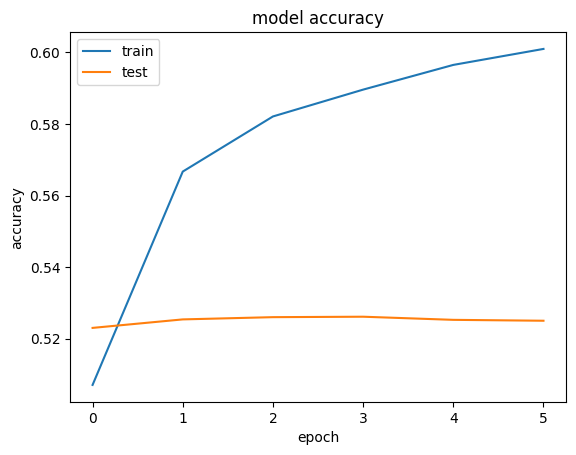

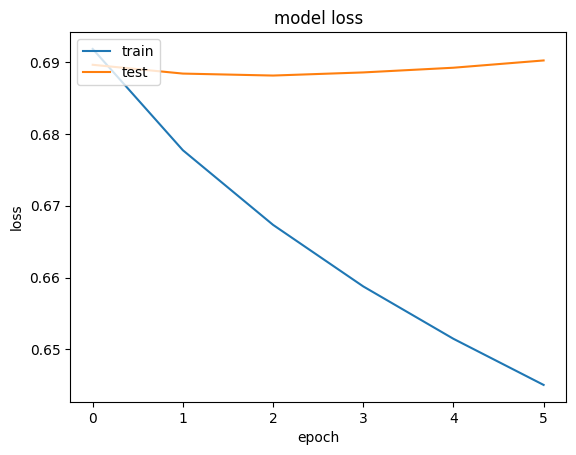

In [32]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from keras.layers import Conv1D

In [ ]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 27s 105ms/step - loss: 0.4672 - acc: 0.7751 - val_loss: 0.3811 - val_acc: 0.8301
Epoch 2/6
250/250 [==============================] - 23s 92ms/step - loss: 0.3370 - acc: 0.8546 - val_loss: 0.3480 - val_acc: 0.8480
Epoch 3/6
250/250 [==============================] - 23s 93ms/step - loss: 0.2814 - acc: 0.8874 - val_loss: 0.3426 - val_acc: 0.8481
Epoch 4/6
250/250 [==============================] - 23s 93ms/step - loss: 0.2364 - acc: 0.9126 - val_loss: 0.3339 - val_acc: 0.8512
Epoch 5/6
250/250 [==============================] - 23s 93ms/step - loss: 0.1946 - acc: 0.9353 - val_loss: 0.3325 - val_acc: 0.8530
Epoch 6/6
250/250 [==============================] - 23s 92ms/step - loss: 0.1596 - acc: 0.9536 - val_loss: 0.3386 - val_acc: 0.8528


In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 0.3357 - acc: 0.8579


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3356787860393524
Test Accuracy: 0.8579000234603882


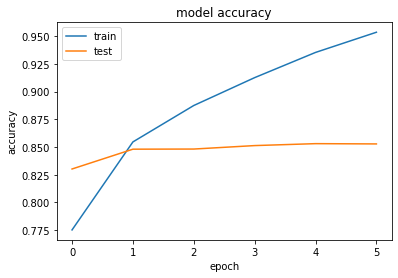

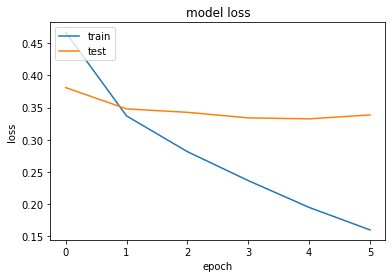

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
from keras.layers import LSTM

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 82s 320ms/step - loss: 0.5498 - acc: 0.7266 - val_loss: 0.4619 - val_acc: 0.7909
Epoch 2/6
250/250 [==============================] - 79s 317ms/step - loss: 0.4309 - acc: 0.8056 - val_loss: 0.4138 - val_acc: 0.8207
Epoch 3/6
250/250 [==============================] - 80s 319ms/step - loss: 0.3883 - acc: 0.8302 - val_loss: 0.3593 - val_acc: 0.8457
Epoch 4/6
250/250 [==============================] - 80s 318ms/step - loss: 0.3506 - acc: 0.8489 - val_loss: 0.3402 - val_acc: 0.8564
Epoch 5/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3259 - acc: 0.8621 - val_loss: 0.3239 - val_acc: 0.8585
Epoch 6/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3067 - acc: 0.8712 - val_loss: 0.3148 - val_acc: 0.8670


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 11s 34ms/step - loss: 0.3194 - acc: 0.8643


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31936636567115784
Test Accuracy: 0.864300012588501


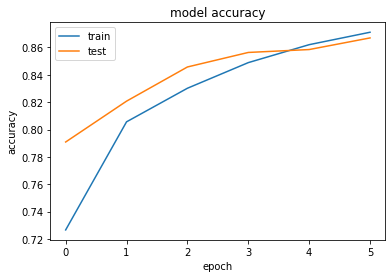

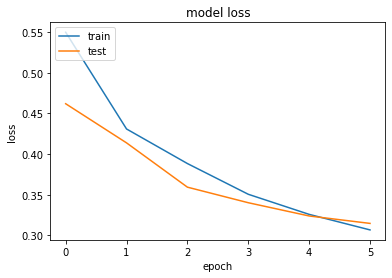

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')